In [174]:
import torch
import pandas as pd
import pandas as pd

import torch.nn.functional as F

from torch_geometric import nn
from torch_geometric import transforms as T
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.data import HeteroData

from sklearn.preprocessing import MinMaxScaler

In [175]:
class BookReview:
    """Book Review dataset
    Attributes:
        + user_id: user's id (0 -> 67698)
        + age: user'age
        + city: user's city location
        + state: user's state location
        + country: user's country location
        + isbn: book identify (67698 -> 138700)
        + book_title: book's title
        + book_author: book's author
        + year_of_publication: books's publication year
        + rating: the score user rate for the book
        + Summary_{1,24}: the description of book embedded by BERT
    """

    def __init__(self, path: str) -> None:
        self._path = path

    def _load_dataset(self) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        summary_attr = [f"Summary_{i}" for i in range(1, 35)]
        user_attributes = ["user_id", "age", "city", "state", "country"]
        book_attributes = [
            "isbn",
            "book_title",
            "book_author",
            "year_of_publication",
        ] + summary_attr

        df = pd.read_csv(self._path)
        users_df = df[user_attributes].reset_index(drop=True)
        books_df = df[book_attributes].reset_index(drop=True)
        rating_df = df[["user_id", "isbn", "rating"]].reset_index(drop=True)

        return users_df, books_df, rating_df

    def __call__(self) -> HeteroData:
        data = HeteroData()
        users_df, books_df, rating_df = self._load_dataset()
        y = torch.from_numpy(rating_df["rating"].to_numpy())
        edge_index = torch.from_numpy(
            rating_df[["user_id", "isbn"]].values.transpose()
        )

        data.name = "Book rating"
        data["users"].node_id = torch.from_numpy(
            users_df["user_id"].values
        ).to(dtype=torch.int64)
        data["books"].node_id = torch.from_numpy(books_df["isbn"].values).to(
            dtype=torch.int64
        )
        data.number_of_users = len(users_df["user_id"].unique())
        data.number_of_books = len(books_df["isbn"].unique())
        books_df.drop(["isbn"], inplace=True, axis=1)
        users_df.drop(["user_id"], inplace=True, axis=1)
        data.number_of_nodes = data.number_of_users + data.number_of_books
        data.number_of_user_node_features = len(users_df.columns)
        data.number_of_book_node_features = len(books_df.columns)

        feat_users_scaler = MinMaxScaler().fit_transform(users_df.to_numpy())
        feat_books_scaler = MinMaxScaler().fit_transform(books_df.to_numpy())
        data["users"].x = torch.from_numpy(feat_users_scaler)
        data["books"].x = torch.from_numpy(feat_books_scaler)
        data["users", "rating", "books"].edge_index = edge_index
        data["users", "books"].edge_label = y
        return data

In [176]:
book_review_dataset = BookReview(
    path="../data/processed/BookReviewDataset_1_XS.csv"
)
dataset = book_review_dataset()
dataset = T.ToUndirected()(dataset)

In [177]:
dataset

HeteroData(
  name='Book rating',
  number_of_users=51,
  number_of_books=1634,
  number_of_nodes=1685,
  number_of_user_node_features=4,
  number_of_book_node_features=37,
  users={
    node_id=[1679],
    x=[1679, 4]
  },
  books={
    node_id=[1679],
    x=[1679, 37]
  },
  (users, rating, books)={
    edge_index=[2, 1679],
    edge_label=[1679]
  },
  (books, rev_rating, users)={
    edge_index=[2, 1679],
    edge_label=[1679]
  }
)

In [178]:
class HyperParameters:
    BATCH_SIZE = 1024
    EPOCHS = 100
    LEARNING_RATE = 0.001
    DECAY = 0.0001

For the inductive model, we should split data into train and test sets. We use 80% data for training and 20% for testing. In the link prediction task, we will use the edge's information. So we use 70% for message passing and 30% for supervising. Generating negative/positive edge, we use 2:1 ratio, negative edges will generate on-the-fly

In [179]:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=True,
    split_labels=True,
    edge_types=("users", "rating", "books"),
    rev_edge_types=("books", "rev_rating", "users"),
)

In [180]:
train, val, test = transform(dataset)

In [181]:
train

HeteroData(
  name='Book rating',
  number_of_users=51,
  number_of_books=1634,
  number_of_nodes=1685,
  number_of_user_node_features=4,
  number_of_book_node_features=37,
  users={
    node_id=[1679],
    x=[1679, 4]
  },
  books={
    node_id=[1679],
    x=[1679, 37]
  },
  (users, rating, books)={
    edge_index=[2, 942],
    pos_edge_label=[403],
    pos_edge_label_index=[2, 403],
    neg_edge_label=[806],
    neg_edge_label_index=[2, 806]
  },
  (books, rev_rating, users)={
    edge_index=[2, 942],
    edge_label=[942]
  }
)

In [182]:
edge_label_index = train["users", "rating", "books"].pos_edge_label_index
edge_label = train["users", "rating", "books"].pos_edge_label

In [183]:
train_loader =  LinkNeighborLoader(
    data=train,
    num_neighbors=[20, 10], #get 2 hops for one node
    neg_sampling_ratio=2.0,
    edge_label_index=(("users", "rating", "books"), edge_label_index),
    edge_label=edge_label,
    batch_size=HyperParameters.BATCH_SIZE,
    shuffle=True,
)

In [184]:
val_edge_label_index = val['users', 'rating', 'books'].pos_edge_label_index
val_edge_label  = val['users', 'rating', 'books'].pos_edge_label
val_loader = LinkNeighborLoader(
    data=val,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("users", "rating", "books"), val_edge_label_index),
    edge_label=val_edge_label,
    batch_size=HyperParameters.BATCH_SIZE,
    shuffle=True,
)

In [185]:
class BookSage(torch.nn.Module):
    def __init__(
        self,
        num_users: int,
        num_books: int,
        num_layers: int,
        hidden_channel: int,
    ) -> None:
        super(BookSage, self).__init__()
        self.embedding = torch.nn.Embedding(
            num_embeddings=num_users + num_books,
            embedding_dim=hidden_channel,
        )
        self.convs = torch.nn.ModuleList(
            nn.SAGEConv(
                in_channels=hidden_channel,
                out_channels=hidden_channel,
                aggr="max",
            )
            for _ in range(num_layers)
        )

    def forward(self, edge_index: torch.Tensor):
        emb0 = self.embedding.weight
        embs = [emb0]
        emb = emb0

        for conv in self.convs:
            emb = conv(emb, edge_index)
            embs.append(emb)
        out = torch.mean(torch.stack(embs, dim=0), dim=0)
        return emb0, out

    def encode_minibatch(
        self,
        users: torch.Tensor,
        pos_items: torch.Tensor,
        neg_items: torch.Tensor,
        edge_index: torch.Tensor,
    ):
        emb0, out = self(edge_index)
        return (
            out[users],
            out[pos_items],
            out[neg_items],
            emb0[users],
            emb0[pos_items],
            emb0[neg_items],
        )

In [186]:
class BookLight(torch.nn.Module):
    def __init__(
        self,
        num_users: int,
        num_books: int,
        num_layers: int,
        hidden_channel: int,
    ) -> None:
        super(BookLight, self).__init__()
        self.embedding = torch.nn.Embedding(
            num_embeddings=num_users + num_books,
            embedding_dim=hidden_channel,
        )
        self.convs = torch.nn.ModuleList(
            nn.LGConv(
                in_channels=hidden_channel,
                out_channels=hidden_channel,
            )
            for _ in range(num_layers)
        )

    def forward(self, edge_index: torch.Tensor):
        emb0 = self.embedding.weight
        embs = [emb0]
        emb = emb0

        for conv in self.convs:
            emb = conv(emb, edge_index)
            embs.append(emb)
        out = torch.mean(torch.stack(embs, dim=0), dim=0)

        return emb0, out

    def encode_minibatch(
        self,
        users: torch.Tensor,
        pos_items: torch.Tensor,
        neg_items: torch.Tensor,
        edge_index: torch.Tensor,
    ):
        emb0, out = self(edge_index)
        return (
            out[users],
            out[pos_items],
            out[neg_items],
            emb0[users],
            emb0[pos_items],
            emb0[neg_items],
        )

In [187]:
class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float("inf")

    def __call__(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [188]:
def compute_bpr_loss(
    users: torch.Tensor,
    users_emb: torch.Tensor,
    pos_emb: torch.Tensor,
    neg_emb: torch.Tensor,
    user_emb0: torch.Tensor,
    pos_emb0: torch.Tensor,
    neg_emb0: torch.Tensor,
):
    # compute loss from initial embeddings, used for regulization
    reg_loss = (
        (1 / 2)
        * (
            user_emb0.norm().pow(2)
            + pos_emb0.norm().pow(2)
            + neg_emb0.norm().pow(2)
        )
        / len(users)
    )

    # compute BPR loss from user, positive item, and negative item embeddings
    pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
    neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)
    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

    return bpr_loss, reg_loss

In [189]:
model = BookSage(
    num_users=train.number_of_users,
    num_books=train.number_of_books,
    num_layers=4,
    hidden_channel=16,
)

In [190]:
print(model)
number_of_parameters = sum(layer.numel() for layer in model.parameters())
print(f"{number_of_parameters=:,}")

BookSage(
  (embedding): Embedding(1685, 16)
  (convs): ModuleList(
    (0-3): 4 x SAGEConv(16, 16, aggr=max)
  )
)
number_of_parameters=29,072


In [191]:
optimizer = torch.optim.Adam(model.parameters(), lr=HyperParameters.LEARNING_RATE)
er = EarlyStopping(20, 0)
criterion = compute_bpr_loss

In [192]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device}")

cuda


In [193]:
model = model.to(device)

In [194]:
history = {"loss": [], "val_loss": []}
for epoch in range(1, HyperParameters.EPOCHS + 1):
    epoch_losses = []
    epoch_val_losses = []
    optimizer.zero_grad()
    model.train()
    for sample in train_loader:
        sample = sample.to(device)
        (
            user_emb,
            pos_emb,
            neg_emb,
            user_emb0,
            pos_emb0,
            neg_emb0,
        ) = model.encode_minibatch(
            sample["users"].node_id,
            sample["users", "rating", "books"].pos_edge_label_index[1],
            sample["users", "rating", "books"].neg_edge_label_index[1],
            sample["users", "rating", "books"].edge_index,
        )

        bpr_loss, reg_loss = compute_bpr_loss(
            sample["users"].node_id,
            user_emb.unsqueeze(1),
            pos_emb,
            neg_emb,
            user_emb0,
            pos_emb0,
            neg_emb0,
        )
        reg_loss = reg_loss * HyperParameters.DECAY
        loss = bpr_loss + reg_loss
        epoch_losses.append(loss.item())

        loss.backward()
        optimizer.step()

    model.eval()
    for sample in val_loader:
        sample = sample.to(device)
        (
            user_emb,
            pos_emb,
            neg_emb,
            user_emb0,
            pos_emb0,
            neg_emb0,
        ) = model.encode_minibatch(
            sample["users"].node_id,
            sample["users", "rating", "books"].pos_edge_label_index[1],
            sample["users", "rating", "books"].neg_edge_label_index[1],
            sample["users", "rating", "books"].edge_index,
        )

        bpr_loss, reg_loss = compute_bpr_loss(
            sample["users"].node_id,
            user_emb.unsqueeze(1),
            pos_emb,
            neg_emb,
            user_emb0,
            pos_emb0,
            neg_emb0,
        )
        reg_loss = reg_loss * HyperParameters.DECAY
        val_loss = bpr_loss + reg_loss
        epoch_val_losses.append(val_loss.item())
    # if er(epoch_val_losses[-1]):
    #     break
    loss_mean = torch.mean(torch.tensor(epoch_losses))
    val_loss_mean = torch.mean(torch.Tensor(epoch_val_losses))
    history["loss"].append(loss_mean)
    history["val_loss"].append(val_loss_mean)
    print(
        f"Epoch {epoch}: \t Loss: {loss_mean} \t Validation loss: {val_loss_mean}"
    )

Epoch 1: 	 Loss: 2.8081583976745605 	 Validation loss: 1.392889380455017
Epoch 2: 	 Loss: 2.658916473388672 	 Validation loss: 1.4434986114501953
Epoch 3: 	 Loss: 2.7058658599853516 	 Validation loss: 1.4725006818771362
Epoch 4: 	 Loss: 2.2833914756774902 	 Validation loss: 1.191836953163147
Epoch 5: 	 Loss: 2.239060163497925 	 Validation loss: 1.6945600509643555
Epoch 6: 	 Loss: 2.045870542526245 	 Validation loss: 1.2312777042388916
Epoch 7: 	 Loss: 1.9736170768737793 	 Validation loss: 1.2921178340911865


Epoch 8: 	 Loss: 1.8464142084121704 	 Validation loss: 1.300682783126831
Epoch 9: 	 Loss: 1.6871342658996582 	 Validation loss: 1.3051434755325317
Epoch 10: 	 Loss: 1.8500369787216187 	 Validation loss: 1.29183030128479
Epoch 11: 	 Loss: 1.6608368158340454 	 Validation loss: 1.1602191925048828
Epoch 12: 	 Loss: 1.615289568901062 	 Validation loss: 1.151599645614624
Epoch 13: 	 Loss: 1.4809916019439697 	 Validation loss: 1.2373403310775757
Epoch 14: 	 Loss: 1.4543604850769043 	 Validation loss: 1.211085319519043
Epoch 15: 	 Loss: 1.2498046159744263 	 Validation loss: 1.0799736976623535
Epoch 16: 	 Loss: 1.3626720905303955 	 Validation loss: 1.1351860761642456
Epoch 17: 	 Loss: 1.1287139654159546 	 Validation loss: 1.176390528678894
Epoch 18: 	 Loss: 1.1829975843429565 	 Validation loss: 1.119551181793213
Epoch 19: 	 Loss: 1.0377575159072876 	 Validation loss: 1.151658535003662
Epoch 20: 	 Loss: 1.0958855152130127 	 Validation loss: 1.4490807056427002
Epoch 21: 	 Loss: 0.9657763838768005

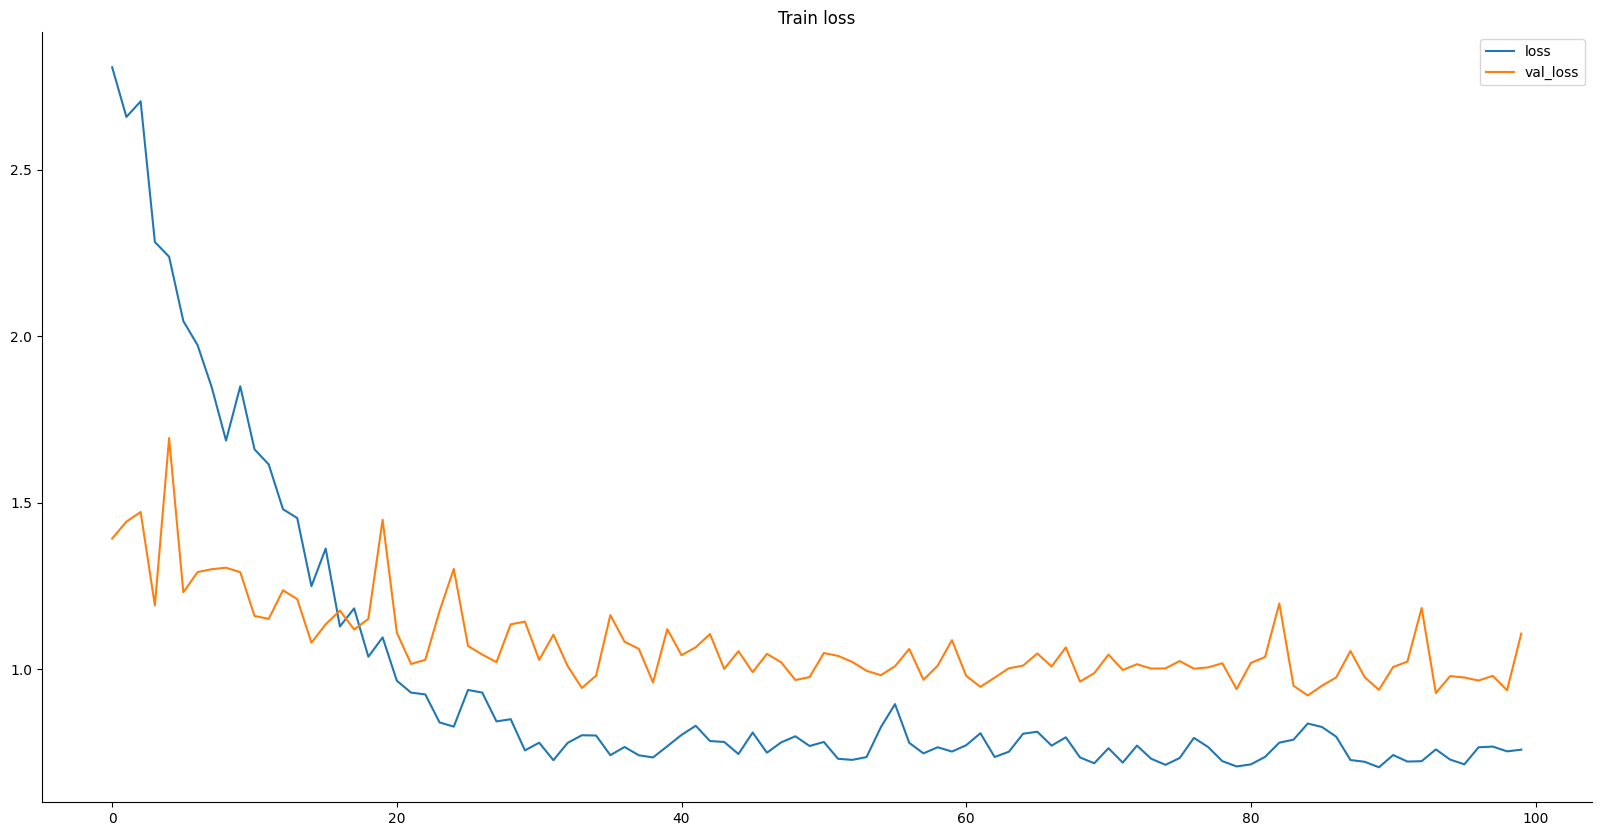

In [195]:
import matplotlib.pyplot as plt

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.figure(figsize=(20, 10))
plt.plot(range(len(history["loss"])), history["loss"])
plt.plot(range(len(history["val_loss"])), history["val_loss"])
plt.title("Train loss")
plt.legend(["loss", "val_loss"])

In [196]:
test_edge_label_index = test['users', 'rating', 'books'].pos_edge_label_index
test_edge_label  = test['users', 'rating', 'books'].pos_edge_label
test_loader = LinkNeighborLoader(
    data=test,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("users", "rating", "books"), test_edge_label_index),
    edge_label=test_edge_label,
    batch_size=HyperParameters.BATCH_SIZE,
    shuffle=True,
)

In [197]:
def get_test_user_interaction(test_data: HeteroData):
    users, items = test_data["users", "rating", "books"].edge_index
    test_df = pd.DataFrame(
        {
            "user_id": users.cpu().numpy().tolist(),
            "items": items.cpu().numpy().tolist(),
        }
    )

    return test_df


def get_item_recommend_and_truth_set(
    user_emb: torch.tensor,
    item_emb: torch.tensor,
    train_data: torch.tensor,
    test_data: torch.tensor,
    K: int,
):
    scores = user_emb @ item_emb.T
    vertices = torch.stack(
        [
            train_data["users"].node_id,
            train_data["books"].node_id,
        ]
    )
    mask = torch.ones(
        (train["users"].node_id.shape[0],),
        dtype=torch.float64,
    )
    interactions = (
        torch.sparse.FloatTensor(
            vertices,
            mask,
            (train.number_of_users, train.number_of_books),
        )
        .to_dense()
        .to(user_emb.device)
    )

    relevance_score = torch.mul(scores, (1 - interactions))

    topk_relevance_score = torch.topk(relevance_score, K).indices
    pred_interaction_user = {"user_id": [], "items": []}
    for user_id, items in zip(
        test_data["users", "rating", "books"].edge_index[0].unique().cpu().numpy().tolist(),
        topk_relevance_score.cpu().numpy().tolist(),
    ):
        pred_interaction_user["user_id"].append(user_id)
        pred_interaction_user["items"].append(items)

    item_recommend_df = pd.DataFrame(pred_interaction_user)
    test_df = get_test_user_interaction(test_data)
    test_items_df = (
        test_df.groupby("user_id")["items"].apply(list).reset_index()
    )
    mask_df = pd.merge(
        test_items_df,
        item_recommend_df,
        how="left",
        left_on="user_id",
        right_on=["user_id"],
    )
    ground_truth = mask_df["items_x"].tolist()
    test_items_list = mask_df["items_y"].tolist()

    return ground_truth, test_items_list

In [198]:
def call_recall_precision(y_true: list, y_pred: list, topk: int):
    recall_items = []
    precision_items = []
    for truth_row, pred_row in zip(y_true, y_pred):
        instinct_set = set(truth_row).intersection(set(pred_row))
        recall_items.append(len(instinct_set) / len(truth_row))
        precision_items.append(len(instinct_set) / topk)

    recall = torch.mean(torch.tensor(recall_items))
    precision = torch.mean(torch.tensor(precision_items))
    return recall, precision

In [199]:
recalls_hit = []
precisions_hit = []

HIT = 20

for i in range(HIT):
    recalls = []
    precisions = []

    model.eval()
    with torch.no_grad():
        for sample in test_loader:
            sample = sample.to(device)
            _, out = model(sample["users", "rating", "books"].edge_index)
            user_emb, item_emb = torch.split(
                out, (train.number_of_users, train.number_of_books)
            )

            ground_truth, test_items_list = get_item_recommend_and_truth_set(
                user_emb, item_emb, train, test, 10
            )
            recall, precision = call_recall_precision(
                ground_truth,
                test_items_list,
                10,
            )

            recalls.append(recall.item())
            precisions.append(precision.item())
    recall_mean = torch.mean(torch.Tensor(recalls))
    precision_mean = torch.mean(torch.Tensor(precisions))
    recalls_hit.append(recall_mean)
    precisions_hit.append(precision_mean)

In [200]:
print(f"recall@{HIT}: {torch.mean(torch.tensor(recalls_hit)):.6}")
print(f"precision@{HIT}: {torch.mean(torch.tensor(precisions_hit)):.6}")

recall@20: 0.0
precision@20: 0.0
